#### Install and Load Libs

In [13]:
# !pip install "tensorflow>=2.0.0"
# !pip install --upgrade tensorflow-hub
# !pip install -q git+https://github.com/tensorflow/docs

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tqdm import tqdm

import cv2

import matplotlib.pyplot as plt

seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)

2023-05-13 17:13:49.195314: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-13 17:13:49.195356: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-13 17:13:51.132332: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-13 17:13:51.132469: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-13 17:13:51.132483: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

#### Read Image with OpenCV

In [3]:
file_path = r'data/cat.jpg'

# define model input image size
input_dim = (224, 224) # height, width

# color read
img = cv2.imread(file_path)
img = cv2.resize(img, input_dim)
height, width, channel = img.shape # height(n_rows), width(n_cols), channel is RGB

# grayscale read
# img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
# height, width = img.shape[0], img.shape[1] 

img.shape

(224, 224, 3)

In [4]:
cv2.imshow("cat", img)
cv2.waitKey(0) # wait for any key
cv2.destroyAllWindows() # close the image window

#### Keras Model (functional API) Example
how to build Keras model with functional API :
this offers more flexblity than sequential model but code can be less intuitive  

In [17]:
input_layer = keras.layers.Input(shape=(height, width))
input_layer.shape # none is where batch(num images) goes

TensorShape([None, 224, 224])

In [18]:
# stack layers
layer1 = keras.layers.Dense(64)(input_layer)
layer2 = keras.layers.Dense(32)(layer1)
output = keras.layers.Dense(2)(layer2) # num of class types to predict

In [19]:
# define model
model = keras.Model(inputs=input_layer, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224)]        0         
                                                                 
 dense_6 (Dense)             (None, 224, 64)           14400     
                                                                 
 dense_7 (Dense)             (None, 224, 32)           2080      
                                                                 
 dense_8 (Dense)             (None, 224, 2)            66        
                                                                 
Total params: 16,546
Trainable params: 16,546
Non-trainable params: 0
_________________________________________________________________


#### Sequential Model Example

In [6]:
# build model
model = keras.Sequential()
model.add(keras.layers.Input(shape=(height, width, channel))) # we'll add channel to input layer this time (color image)
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3))) # get 64 filters of size 3x3
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dense(16))
model.add(keras.layers.Dense(2)) # output layer

model.summary()

2023-05-13 17:31:36.438508: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/seth/anaconda3/envs/ml/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-13 17:31:36.438555: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-13 17:31:36.438596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zephyr): /proc/driver/nvidia/version does not exist


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 dense (Dense)               (None, 222, 222, 32)      2080      
                                                                 
 dense_1 (Dense)             (None, 222, 222, 16)      528       
                                                                 
 dense_2 (Dense)             (None, 222, 222, 2)       34        
                                                                 
Total params: 4,434
Trainable params: 4,434
Non-trainable params: 0
_________________________________________________________________


#### Experimenting with layers

**test model input**

In [7]:
# model expects image to come in batch (np array of multiple images)
# such as [img1, img2, img3, ...] but only one img this time
img_batch = np.array([img])


# display model outputs to see if model is working
result = model(img_batch)
result.shape

TensorShape([1, 222, 222, 2])

##### View Filters

In [8]:
# we'll try to get parameters from Conv2D layer (first layer in the model)
filters, _ = model.layers[0].get_weights()
filters.shape # numpy array of height, width, channel, n_filter_images

(3, 3, 3, 64)

In [9]:
# normalize (MinMax Scale) the filter values in range (0 to 1)

# for grayscale (only one channel)
# fmin, fmax = filters.min(), filters.max()
# filters = (filters - fmin) / (fmax-fmin)

# for color imgs (3 channels) so I'll try normalizing each channel separately
ch1 = filters[:,:,0,:]
ch2 = filters[:,:,1,:]
ch3 = filters[:,:,2,:]
ch1min, ch1max = ch1.min(), ch1.max()
ch2min, ch2max = ch2.min(), ch2.max()
ch3min, ch3max = ch3.min(), ch3.max()
filterch1 = (ch1-ch1min) / (ch1max - ch1min)
filterch2 = (ch2-ch2min) / (ch2max - ch2min)
filterch3 = (ch3-ch3min) / (ch3max - ch3min)
filters = np.array([filterch1, filterch2, filterch3])

First 3,3 is size of image(filter). Last 64 means there are 64 images of size 3x3.<br> But in this case we have 3 channels so the total images (filters) will be 64 x 3 number of images with size 3x3.

In [10]:
# access and display first filter

# filters[height, width, channel, image]
f0 = filters[:,:,:,0]  # the first filter image among 64
f0

array([[[0.38442168, 0.78667086, 0.31280422],
        [0.3580959 , 0.43837297, 0.3584337 ],
        [0.43436   , 0.9817637 , 0.43445694]],

       [[0.43019912, 0.5505775 , 0.5546816 ],
        [0.9137355 , 0.8977516 , 0.693482  ],
        [0.94819874, 0.84070325, 0.85519063]],

       [[0.73254025, 0.20581849, 0.21554728],
        [0.95515656, 0.425193  , 0.31602526],
        [0.22828242, 0.37460533, 0.63229805]]], dtype=float32)

In [12]:
for i in range(5):
    filter = filters[:,:,:,i]
    # resize and view image cuz 3x3 pixels image is tiny
    filter = cv2.resize(filter, input_dim, interpolation=cv2.INTER_NEAREST)
    cv2.imshow(str(i), filter)
    
cv2.waitKey(0)
cv2.destroyAllWindows() # close the image window

#### Feature Maps

In [13]:
# build model
model = keras.Sequential()
model.add(layers.Conv2D(input_shape = (*input_dim,3), filters=64, kernel_size=(3,3)))

# predict
feature_map = model.predict(np.array([img]))
feature_map.shape  # input_img, height, width, filter_imgs

1/1 [==============================] - 0s 341ms/step


(1, 222, 222, 64)

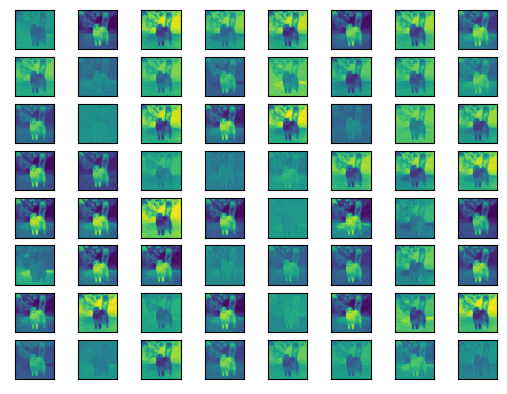

In [14]:
for i in range(64):
    feature_img = feature_map[0, :, :, i]
    
    ax = plt.subplot(8,8, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_img)
    
plt.show()

#### Max Pooling

In [15]:
# build model
model = keras.Sequential()
model.add(layers.Conv2D(input_shape = (*input_dim,3), filters=64, kernel_size=(3,3)))

# square of 2x2 maxpool that moves(strides) by 1 pixel to left and 1 to bottom
# if large stride number, the maxpool square will move fast (skip pixels)
# and result in image with fewer pixels  
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(1,1))) 

# predict
feature_map = model.predict(np.array([img]))
feature_map.shape  # input_img, height, width, filter_imgs

1/1 [==============================] - 0s 89ms/step


(1, 221, 221, 64)

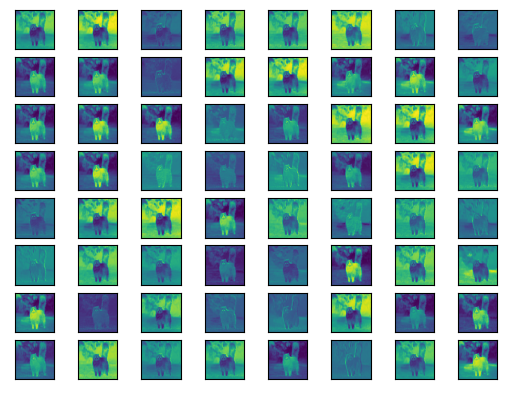

In [16]:
for i in range(64):
    feature_img = feature_map[0, :, :, i]
    
    ax = plt.subplot(8,8, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_img)
    
plt.show()

#### Flattern

In [33]:
# build model
model = keras.Sequential()
model.add(layers.Conv2D(input_shape = (*input_dim,3), filters=64, kernel_size=(3,3)))

# square of 2x2 maxpool that moves(strides) by 1 pixel to left and 1 to bottom
# if large stride number, the maxpool square will move fast (skip pixels)
# and result in image with fewer pixels 
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(1,1))) 

model.add(layers.Flatten())

model.add(layers.Dense(units=5)) # units = number of classes to predict

# predict
result = model.predict(np.array([img]))
print(result.shape)  # input_img, height, width, filter_imgs
print(result)

2023-03-29 23:01:00.842779: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 62516480 exceeds 10% of free system memory.
2023-03-29 23:01:00.882582: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 62516480 exceeds 10% of free system memory.
2023-03-29 23:01:00.907645: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 62516480 exceeds 10% of free system memory.


1/1 [==============================] - 0s 133ms/step
(1, 5)
[[-36.215874  42.523003 -20.600323  18.572706  11.423247]]
